In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn.apionly as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from scipy import interp

from composition.analysis.load_sim import load_sim
from composition.analysis.preprocessing import get_train_test_sets
from composition.analysis.features import get_training_features
from composition.analysis.pipelines import get_pipeline

%matplotlib inline

/home/jbourbeau/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
sns.set_palette('muted')
sns.set_color_codes()

In [3]:
df, cut_dict = load_sim(return_cut_dict=True)
selection_mask = np.array([True] * len(df))
standard_cut_keys = ['reco_exists', 'reco_zenith', 'num_hits', 'IT_signal',
                     'StationDensity', 'max_charge_frac', 'reco_containment',
                     'min_energy', 'max_energy']
for key in standard_cut_keys:
    selection_mask *= cut_dict[key]

df = df[selection_mask]

feature_list = get_training_features()
X_train, X_test, y_train, y_test, le = get_train_test_sets(df, feature_list)

print('events = ' + str(y_train.shape[0]))

/home/jbourbeau/composition/analysis/load_sim.py:40: RuntimeWarning: divide by zero encountered in log10
  cut_dict['min_energy'] = (np.log10(df['reco_energy']) > 6.2)
/home/jbourbeau/composition/analysis/load_sim.py:41: RuntimeWarning: divide by zero encountered in log10
  cut_dict['max_energy'] = (np.log10(df['reco_energy']) < 8.0)
/home/jbourbeau/composition/analysis/load_sim.py:57: RuntimeWarning: divide by zero encountered in log10
  df['reco_log_energy'] = np.nan_to_num(np.log10(df['reco_energy']))
/home/jbourbeau/composition/analysis/load_sim.py:58: RuntimeWarning: invalid value encountered in log10
  df['InIce_log_charge'] = np.nan_to_num(np.log10(df['InIce_charge']))


events = 76442


In [8]:
pipeline = get_pipeline('RF')

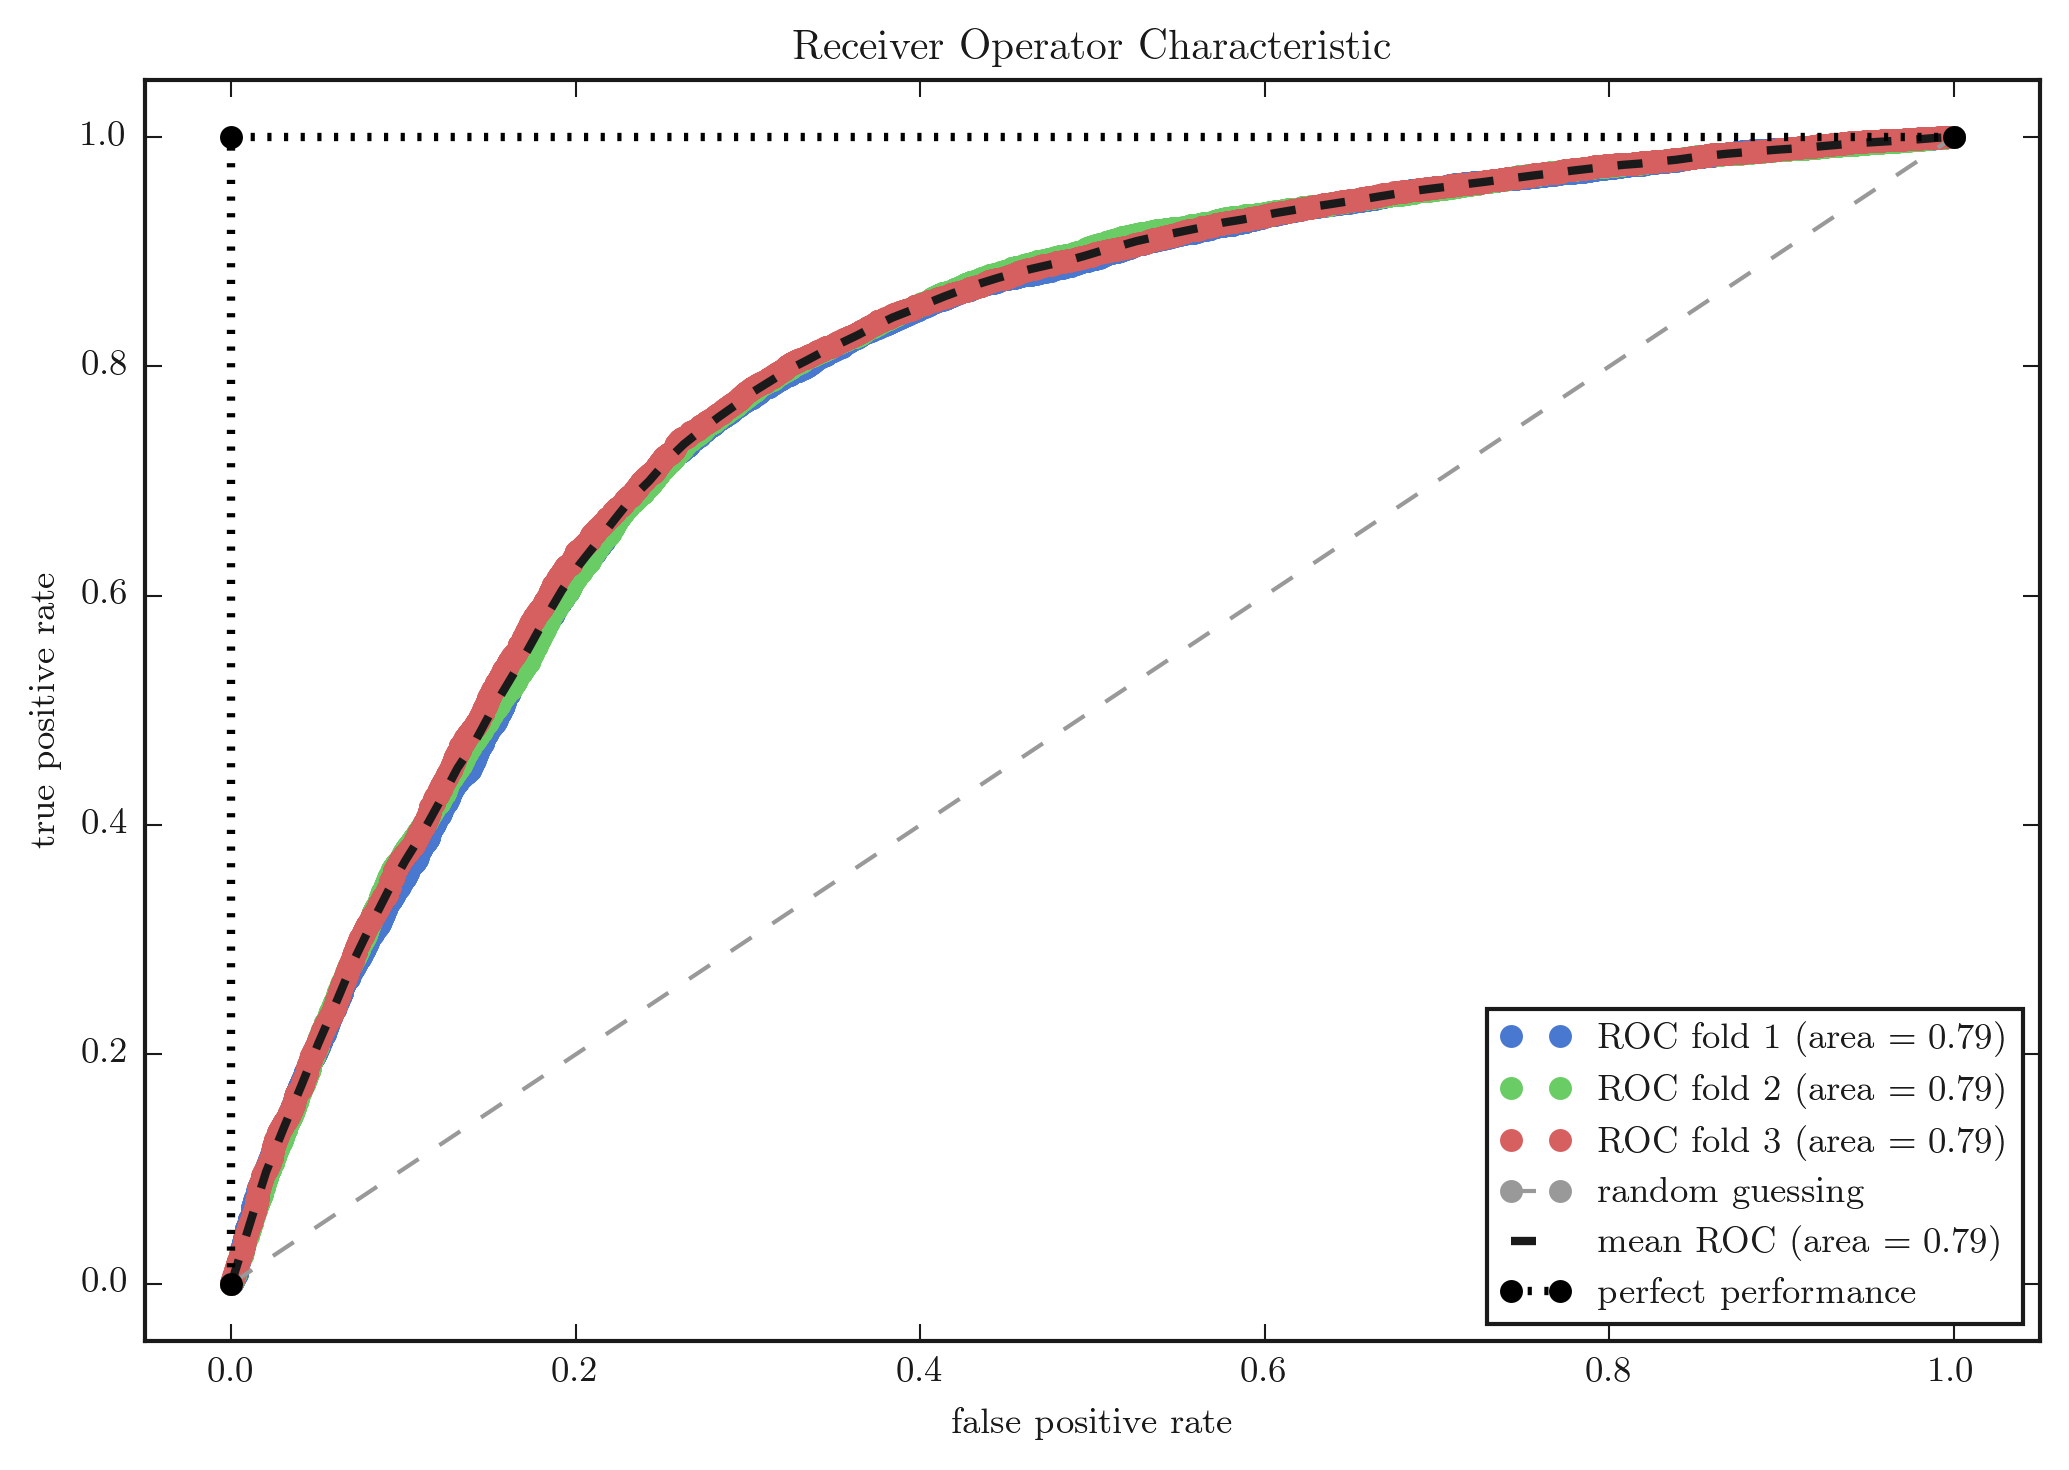

In [11]:
cv = list(StratifiedKFold(n_splits=3, random_state=1).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipeline.fit(X_train[train],
                         y_train[train]).predict_proba(X_train[test])

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             lw=1,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         lw=2,
         linestyle=':',
         color='black',
         label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc="lower right")

plt.tight_layout()
# plt.savefig('./figures/roc.png', dpi=300)
plt.show()